In [75]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.regularizers import L1L2
from keras import optimizers
import matplotlib.pyplot as plt
import plotly.express as px

In [76]:
## Config
k = 28
## Data
# abw = pd.read_csv("~/user/Downloads/sqllab_query_dispense_luaabwasser_lua_20220317T205021.csv").set_index("meldedatum").dropna().filter(("sum_7tage", "sum_14tage"))
abw = pd.read_csv(
    "~/user/Downloads/20220328_103135.csv", parse_dates=True
).rename(columns={"Abwasser 7T": "sum_7tage", "Abwasser Täglich": "daily", "__timestamp": "Meldedatum"}).set_index("Meldedatum")
abw["sum_14tage"] = abw["daily"].rolling(14, min_periods=1).sum()
abw["sum_28tage"] = abw["daily"].rolling(28, min_periods=1).sum()
abw.index = pd.to_datetime(abw.index).strftime("%Y-%m-%d")
rki = pd.read_csv("Dresden_RKI_data.csv").set_index("Refdatum")
impf = pd.read_csv("Dresden_Impfungen.csv").set_index("Impfdatum")
var = pd.read_csv("Dresden_Varianten.csv").set_index("DATE_DRAW")
var["Omikron"] = var["BA.1"] + var["BA.2"]
df = abw.join(var).join(rki).join(impf)
df = df.fillna(method="ffill").fillna(method="bfill")
df.index = pd.to_datetime(df.index)
df = df.interpolate("time", axis=0)
# df.index = pd.to_datetime(df.index)
# df.plot(figsize=(20,6))
px.line(df, title="Input Data")
# df.isna().any()


In [77]:
## Prepare windowed data
scaler = MinMaxScaler()
# df_scaled = df.copy().filter(("sum_14tage", "sum_7tage", "rki_14tage", "rki_7tage"))#, "Omikron"))
df_scaled = df.copy().filter((f"sum_{k}tage",)).join(df.filter(regex=f"^rki_{k}\w+"))
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index).join(df.filter(("Alpha", "Delta", "BA.1", "BA.2", "Omikron"))).join(df.filter(regex="(Booster|Doppelt).*"))
# df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index).join(df.filter(("Alpha", "Delta", "BA.1", "BA.2"))).join(df.filter(regex="(Booster|Doppelt).*"))
# df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index).join(df.filter(("Alpha", "Delta", "Omikron"))).join(df.filter(regex="(Booster|Doppelt).*"))
# df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df.index).join(df.drop(df.filter(regex=r"(\w+tage)").columns, axis=1))
X = np.array([win.values.transpose() for win in df_scaled.filter(regex=f"^(?!rki_{k}tage)").rolling(30) if len(win) == 30][:-1])
y = np.array([win.values[-1] for win in df_scaled.filter((f"rki_{k}tage",)).rolling(31) if len(win) == 31])
# X_train, X_test, y_train, y_test = train_test_split(X[:-30,:,:], y[:-30,:], random_state=1) # exclude last 30 days
X_train, X_test, y_train, y_test = train_test_split(X[:-14,:,:], y[:-14,:], random_state=1) # exclude last 14 days
# df_scaled.plot(figsize=(20, 5))
px.line(df_scaled)


Epoch 1/100
8/8 [==============================] - 2s 72ms/step - loss: 0.4189 - val_loss: 0.4049
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.4007 - val_loss: 0.3890
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3852 - val_loss: 0.3737
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.3691 - val_loss: 0.3583
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.3539 - val_loss: 0.3426
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.3375 - val_loss: 0.3268
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3215 - val_loss: 0.3105
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 0.3078 - val_loss: 0.2977
Epoch 9/100
8/8 [==============================] - 0s 19ms/step - loss: 0.2935 - val_loss: 0.2863
Epoch 10/100
8/8 [==============================] - 0s 19ms/step - loss: 0.2825 - val_loss: 0.2740
Epoch 11/100
8/8 [=

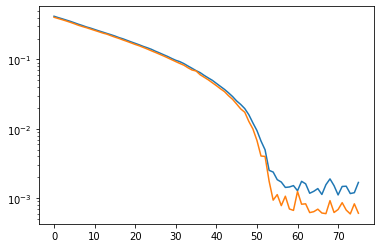

In [78]:
## LSTM
model = Sequential()
model.add(layers.LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2]), bias_regularizer=L1L2(l1=0.01, l2=0.01), recurrent_dropout=0.1))
# model.add(layers.Dropout(0.05))
model.add(layers.Dense(1))
model.compile(loss="mse", optimizer=optimizers.adam_v2.Adam(learning_rate=.005))
# model.compile(loss="mse", optimizer="Adam")
# fit network
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    # verbose=1,
    shuffle=False,
    callbacks=[callback]
)
plt.semilogy(pd.DataFrame(history.history))
plt.show()

In [79]:
pred = model.predict(X)
df_pred = df_scaled.copy()
df_pred["pred"] = np.pad(np.squeeze(pred), [X.shape[-1], 0], constant_values=np.nan)
df_pred[df_pred < 0] = 0
df_pred["error"] = df_pred["pred"] - df_pred[f"rki_{k}tage"]
# df_pred.plot(figsize=(15,6), style={"pred": ".", "error": "-."})
px.line(df_pred)
# plt.figure(figsize=(15,6))
# plt.plot(pred, "r")
# plt.plot(y)
# plt.plot(pred-y)
# plt.legend(("predicted", "original", "error"))
# model.evaluate(X_test, y_test)

In [ ]:
## Random forest
regr = RandomForestRegressor(n_estimators=200)#, max_depth=6, random_state=0)
X = df.filter(("geimpft", "sum_14tage", "sum_7tage", "Alpha", "BA.1", "BA.2", "Delta")).astype(float).values
y = df["lua_14tage"].astype(float).values
regr.fit(X,y)
df["prediction"] = regr.predict(X)
df.filter(("lua_14tage", "sum_14tage", "sum_7tage", "prediction", "Alpha", "BA.1", "BA.2", "Delta")).plot(secondary_y=("sum_14tage", "sum_7tage"), figsize=(15, 5), title="Random Forest")

In [ ]:
## MLP
# print(y_train)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
regr.predict(X_test[:2])
regr.score(X_test, y_test)